In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
import requests
import time
import pickle
import platform
import tqdm

## Prepareing Data
+ Download
+ Labeling
+ Spliting

In [2]:
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

### Data Download

In [3]:
# def download_process_bar(count, block_size, total_size):
#     completed = float(count * block_size) / total_size
#     msg = "\r- Download progress: {0:.1%}".format(completed)
#     # Print it.
#     sys.stdout.write(msg)
#     sys.stdout.flush()

In [4]:
# def download_process_bar(data_url):
#     file_size = int(requests.head(data_url).headers["Content-Length"])

#     if file_size:
#         r = requests.get(data_url, stream=True)
#         chunk_size = 1024
#         total_chunks = int(file_size / chunk_size) + 1

#         for i, chunk in enumerate(r.iter_content(chunk_size=chunk_size)):
#             with open("file.zip", "ab") as f:
#                 f.write(chunk)
#             percent = int(i / total_chunks * 100)
#             sys.stdout.write("\r[%s%s] %d%%" % ("=" * percent, " " * (100 - percent), percent))
#             sys.stdout.flush()

#     print("\nDownload complete")

In [5]:
def download_file(url, directory):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress = tqdm.tqdm(total=total_size, unit='B', unit_scale=True)
    file_name = url.split("/")[-1]
    path = os.path.join(directory, file_name)
    
    with open(path, "wb") as f:
        for data in response.iter_content(block_size):
            progress.update(len(data))
            f.write(data)
    progress.close()

In [6]:
def download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    :param download_dir: Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    """
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
#         # Check if the download directory exists, otherwise create it.
#         if not os.path.exists(download_dir):
#             os.makedirs(download_dir)

#         # Download the file from the internet.
#         file_path, _ = urllib.request.urlretrieve(url=url,
#                                                   filename=file_path,
#                                                   reporthook=download_process_bar)
        download_file(url,download_dir)
        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Extraction is Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        

### Loading Data

In [7]:
def load_binary(f):
    ver = platform.python_version_tuple()
    if ver[0]=='3':
        return pickle.load(f, encoding='latin1')
    else :
        return ValueError("invalid python version: {}".format(version))

In [8]:
def load_cifar_batch(filename):
    with open(filename,'rb') as f:
        data = load_binary(f)
        x = data['data']
        y = data['labels']
        x = x.reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
        y = np.array(y)
        return x,y

In [9]:
def load_cifar10(rootdir):
    indipendent = []
    dependent = []
    
    for b in range(1,6):
        F = os.path.join(rootdir,'data_batch_%d'%(b,))
        X , Y = load_cifar_batch(F)
        indipendent.append(X)
        dependent.append(Y)
    xtrain = np.concatenate(indipendent)
    ytrian = np.concatenate(dependent)
    del indipendent, dependent
    xtest, ytest = load_cifar_batch(os.path.join(rootdir,'test_batch'))
    
    return xtrain, ytrian, xtest, ytest

## KNN Class define

In [10]:
class KNN_image_classifier():
    
    def __init__(self):
        pass
    
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y
        
    def claculate_distance(self,X):
#         n_test = X.shape[0]
#         n_train = self.xtrain.shape[0]
#         dist = np.zeros((n_test,n_train))
#         dist = np.sqrt(
#             np.sum(np.square(self.xtrain),axis = 1) + 
#             np.sum(np.square(X),axis = 1)[:,np.newaxis] - 2 * np.dot(X, self.xtrain.T))
        
#         return dist
            num_test = X.shape[0]
            num_train = self.X_train.shape[0]
            dists = np.zeros((num_test, num_train)) 
            dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
            pass
            return dists
    
    def predict(self,X,k=1):
        dist = self.claculate_distance(X)
        return self.predict_labels(dist,k=k)

    def predict_labels(self,dist,k=1):
        n_test = dist.shape[0]
        y_pred = np.zeros(n_test)
        
        for i in range(n_test):
            closest = []
            sorted_dist = np.argsort(dist[i])
            closest = list(self.y_train[sorted_dist[0:k]])
            y_pred[i] = np.argmax(np.bincount(closest))
            
        return y_pred
    

In [11]:
# !rm "cifar-10-python.tar.gz"
!ls

__notebook_source__.ipynb


In [12]:
download_dir = "/kaggle/working/"

In [13]:
download_and_extract(data_url,download_dir)

100%|██████████| 170M/170M [00:11<00:00, 14.2MB/s] 



Download finished. Extracting files.
Extraction is Done.


In [14]:
!ls "cifar-10-batches-py"

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [15]:
cifar10_dir = "/kaggle/working/cifar-10-batches-py"

In [16]:
X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [17]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
# smaple data checking

def visualizSampleData(classess: list, number: int )->None:
    samples = number
    for lbl, cls in enumerate(classess):
        idxs = np.flatnonzero(y_train == lbl)
        idxs = np.random.choice(idxs, samples, replace = False)
        
        for i, j in enumerate(idxs):
            plt_idx = i * len(classess) + lbl + 1
            plt.subplot(samples, len(classess), plt_idx)
            plt.imshow(X_train[j].astype('uint8'))
            plt.axis('off')
            
            if i == 0:
                plt.title(cls)
                
    plt.show()

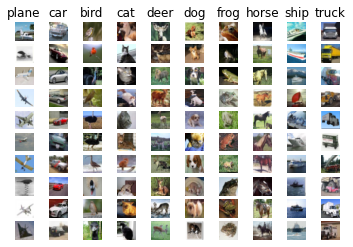

In [19]:
visualizSampleData(classes, number = 10)

In [20]:
# Subsampling of data
traning_size = 50000
test_size = 1000
X_train = X_train[list(range(traning_size))]
y_train = y_train[list(range(traning_size))]

X_test = X_test[list(range(test_size))]
y_test = y_test[list(range(test_size))]

In [21]:
# Changing the shape of the data

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train.shape, X_test.shape

((50000, 3072), (1000, 3072))

## KNN implement

In [22]:
def gerResult(classifier, dist, testData_len, k=1):
    """
    Return the value of correctly classified number and the accuracy of the classifier
    """
    pred = classifier.predict_labels(dist, k)
    correct = np.sum(pred == y_test)
    accuracy = float(correct) / testData_len
    
    return correct, accuracy

In [23]:
classifier = KNN_image_classifier()
classifier.fit(X_train, y_train)

distance = classifier.claculate_distance(X_test)

correct, accuracy = gerResult(classifier, distance, X_test.shape[0], k=5)

print('From %d over %d image is correct.\nAccuracy: %f' % (correct, X_test.shape[0], accuracy))

From 347 over 1000 image is correct.
Accuracy: 0.347000


# C.V

In [24]:
# num_folds = 5
# k_choices = [1, 3, 5, 7, 9, 10, 12, 15, 20, 25, 50, 75, 100]

# X_train_fold = np.array_split(X_train, num_folds)
# y_train_fold = np.array_split(y_train, num_folds)

# accuracies = {}

# for k in k_choices:
#     accuracies[k] = []
    
#     for knn in range(0, num_folds):
#         X_test = X_train_fold[knn]
#         y_test = y_train_fold[knn]
        
#         X_train = X_train_fold
#         y_train = y_train_fold
        
#         temp = np.delete(X_train, knn, 0)
#         x_train = np.concatenate((temp), axis=0)
#         y_train = np.delete(y_train, knn, 0)
#         y_train = np.concatenate((y_train), axis=0)
        
#         classifier = KNN_image_classifier()
#         classifier.fit(X_train, y_train)
        
#         distance = classifier.claculate_distance(X_test, test_size)
#         y_test_pred = classifier.predict_labels(distance, k)

#         num_correct = np.sum(y_test_pred == y_test)
#         accuracy = float(num_correct) / test_size
        
#         accuracies[k].append(accuracy)

# print("f{k}-fold accuracy: ")
# print("+*20")

# for k in sorted(accuracies):
#     for accu in accuracies[k]:
#         print(f"Value of k is {k} and accuracy {accu}")
        
# print("+*20")

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNN_image_classifier()
        classifier.fit(X_train, y_train)
        dists = classifier.claculate_distance(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / test_size
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
num_folds = [1,3,5,7,10,12]
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

for fold in num_folds:
    X_train_folds = []
    y_train_folds = []

    X_train_folds = np.array_split(X_train, fold)
    y_train_folds = np.array_split(y_train, fold)
    k_to_accuracies = {}



    for k in k_choices:
        k_to_accuracies[k] = []
        for num_knn in range(0, fold):
            X_test = X_train_folds[num_knn]
            y_test = y_train_folds[num_knn]
            X_train = X_train_folds
            y_train = y_train_folds

            temp = np.delete(X_train,num_knn,0)
            X_train = np.concatenate((temp),axis = 0)
            y_train = np.delete(y_train,num_knn,0)
            y_train = np.concatenate((y_train),axis = 0)

            classifier = KNN_image_classifier()
            classifier.fit(X_train, y_train)
            dists = classifier.claculate_distance(X_test)
            y_test_pred = classifier.predict_labels(dists, k)

            num_correct = np.sum(y_test_pred == y_test)
            accuracy = float(num_correct) / test_size
    #         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
            k_to_accuracies[k].append(accuracy)


    print(f"Printing our {fold}-fold accuracies for varying values of {k}:")
    print()
    for k in sorted(k_to_accuracies):
        for accuracy in k_to_accuracies[k]:
            print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# import plotly.graph_objects as go
# import plotly.express as px
# fig = go.Figure(data=go.Scatter(
#         x=[1, 2, 3, 4],
#         y=[2, 1, 3, 4],
#         error_y=dict(
#             type='data',
#             symmetric=False,
#             array=[0.1, 0.2, 0.1, 0.1],
#             arrayminus=[0.2, 0.4, 1, 0.2])
#         ))
# fig.show()

In [ ]:
for k in k_choices:
    accu = k_to_accuracies[k]
    fig = px.)
    
accu_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accu_std =  np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
fig = go.Figure(data=go.Sctter([k] * len(accu), accu), 
    error_y=dict(type='data',sysmmetic=False, accu_mean, accu_std))
